# Lab Assignment 5 of Image Processing
**Mansi Kakkar**

**EE21S063**

-------

## SPACE VARIANT BLURRING

**IMPORTING LIBRARIES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

In [2]:
!ls

Globe.png            Nautilus.png
Lab_05.pdf           PA(5)_EE21S063.ipynb


**READING IMAGES**

In [3]:
#READING IMAGES

globe = io.imread('Globe.png')
nautilus = io.imread('Nautilus.png')

In [4]:
np.shape(globe)

(195, 195)

**KERNEL SIZE**

This function is defined to get the kernel size $6\sigma+1$

Kernel size has to be taken in such a way that it is odd

In [5]:
#GETTING KERNEL SIZE

def kernel_size(sigma):
    #defining window size
    size = np.ceil(6*sigma)+1
    #checking whether it is odd or not ; if not then incrementing the size to odd
    #try and except condition has been taken such that this function could go for both
    #sigma matrix as well as single sigma value
    try:
        size[size % 2 == 0]+=1
        return size.astype(np.int)
    except:
        if size%2 == 0:
            size = size+1
        return int(size)

**ZERO PADDED IMAGE**

Getting zero padded image for the boundary pixels and kernel size wont match with the size of fragment of image while convoluting. 

In [6]:
#GETTING ZERO PADDED IMAGE
def zero_padded_image(source, size):
    #padding size
    p = size//2
    [x,y] = np.shape(source)
    new_img = np.zeros((x+2*p,y+2*p))
    #New Image
    new_img[p:-p,p:-p] = source
    return new_img

**SIGMA**

For the blur to be space-variant, i.e. the standard deviation varies for each pixel. Consider the distribution of $\sigma$ to be:





$\sigma(m,n) = A\exp\frac{-((m-\frac{N}{2})^2+(n-\frac{N}{2})^2)}{B}$ ,  0 ≤ m,n ≤ N − 1.



---

with two initial conditions,

$\sigma(\frac{N}{2},\frac{N}{2}) = 2.0$   and   $\sigma(0,0) = 0.01$

---

where $N × N$ is size of the image and pixel indices are in the range $[0,N −1]×[0,N −1]$. 


---

Using given conditions we are finding A and B, and then will create a matrix $\sigma$

---

$A = \sigma(\frac{N}{2},\frac{N}{2}) = 2.0$

---

$B = \frac{N^2}{2\log(\frac{A}{\sigma(0,0)})}$

In [7]:
#GETTING VALUES OF A AND B 
def get_AB(i_N_by_2,i_0,N):
    A = i_N_by_2
    B = N**2/(2*np.log(A/i_0))
    return A,B

**GETTING SIGMA AS DEFINED ABOVE**

In [8]:
#GETTING SIGMA
def get_sigma(A,B,N):
    #creating blank sigma matrix of size NXN
    sigma = np.zeros((N,N))
    for m in range(N):
        for n in range(N):
            sigma[m,n] = A*(np.exp(-((m-(N/2))**2+(n-(N/2))**2)/B))
    return sigma

**DEFINING GAUSSIAN KERNEL**

Constructing the Gaussian Kernel with Normal Distibution formula given standard deviation &\sigma$ . 

---

The Gaussian Kernel is defined as : 

$G(i,j) = \frac{1}{2\pi\sigma^2} \exp^{\frac{-x^2 - y^2}{2 \sigma^2}}$

---

We have nomalised it as the entries of G might not sum upto 1, such that

$G(i,j) = \frac{1}{2\pi\sigma^2 S} \exp^{\frac{-x^2 - y^2}{2 \sigma^2}}$

---

Since, we have done this in class as well that the kernel's values must sum upto 1 otherwise if would experience variations in the image


In [18]:
#Defining Gaussian Kernel
def gaussian_kernel(size,sigma):
    
    #creating blank kernel
    kernel = np.zeros((size, size))
    #absolute half of the size
    s_c = size//2
    
    #for condition where sigma is 0
    if size==1:
        kernel = np.ones((size, size))
        return kernel
    
    #defining kernel
    for x in range(size):
        for y in range(size):
            temp = np.exp((-((x-s_c)**2)-((y-s_c)**2))/(2*(sigma**2)))
            kernel[x,y] = temp / (2*np.pi*(sigma**2))
            
    #dividing by th sum of kernel
    kernel = kernel/np.sum(kernel)
    return kernel

**2D CONVOLUTION FOR SPACE INVARIANT BLUR**

In [19]:
#2D Convolution
def convolution_2D(source, sigma):
    #Getting the shape of the image
    [x, y] = np.shape(source)
    size = kernel_size(sigma)
    p = size//2
    #If the size of the kernel is 1, return the original image
    if size==1:
        return source
    #getting the padded image
    padded_image = zero_padded_image(source, size)
    #getting the kernel
    kernel = gaussian_kernel(size,sigma)
    #flipping the kernel for convolution operation
    kernel = kernel[::-1, ::-1]
    #constructing blank convolved image
    convolved_image = np.zeros((x,y))
    
    #performing convolution
    for i in range(p, x+p):
        for j in range(p, y+p):
            #taking blank matrix of size = kernel's size 
            #to perform multiplication of indivisual elements of the matrices
            mat = padded_image[i-p:i+p+1, j-p:j+p+1]
            convolved_image[i-p,j-p] = np.sum(mat*kernel)
    return convolved_image
    

**SPACE VARIANT BLUR**



In [20]:
#SPACE VARIANT BLUR1

def space_variant_blur1(source, sigma_matrix):
    #size of image
    [x,y] = np.shape(source)
    #storing kernel size for respective sigmas in sigma matrix
    #to size 
    size = kernel_size(sigma_matrix)
    #calculating maximum size from size array such that 
    #the image is padded with the maximum kernel size 
    #so that we dont face any issues further
    max_size = np.max(size)
    p = max_size//2
    #padded image
    padded_image = zero_padded_image(source, max_size)
    #creating blank image
    image = np.zeros_like(padded_image)
    #creating blank kernel array for storing kernels such that 
    #repeatedly they are not computed for same sigma values
    kernels = {}
    #performing gaussian blur
    for i in range(p,x+p):
        for j in range(p,y+p):
            #extracting one sigma at a time
            sigma = sigma_matrix[i-p,j-p]
            #getting image intensity
            intensity = source[i-p,j-p]
            w = size[i-p, j-p]
            d=w//2
            kernel = gaussian_kernel(w, sigma)
            kernels[sigma] = (w, d, kernel)
            #multiplying the kernel with the image intensity at that coordinate
            #and add that value to the canvas
            image[i-d:i+d+1, j-d:j+d+1]+= intensity*kernel
    return image

In [21]:
#SPACE VARIANT BLUR2

def space_variant_blur2(source, sigma_matrix):
    #size of image
    [x,y] = np.shape(source)
    #storing kernel size for respective sigmas in sigma matrix
    #to size 
    size = kernel_size(sigma_matrix)
    #calculating maximum size from size array such that 
    #the image is padded with the maximum kernel size 
    #so that we dont face any issues further
    max_size = np.max(size)
    p = max_size//2
    #padded image
    padded_image = zero_padded_image(source, max_size)
    #creating blank image
    image = np.zeros_like(padded_image)
    #creating blank kernel array for storing kernels such that 
    #repeatedly they are not computed for same values for different sigma values
    kernels = {}
    #performing gaussian blur
    for i in range(p,x+p):
        for j in range(p,y+p):
            #extracting one sigma at a time
            sigma = sigma_matrix[i-p,j-p]
            #getting image intensity
            intensity = source[i-p,j-p]
            #if sigma for a particular kernel is already calculated, that would be used
            #instead of reconputing it
            if sigma in kernels.keys():
                w, d, kernel = kernels[sigma]
            #else calculate that kernel, w, and d values and save them
            else:
                w = size[i-p, j-p]
                d=w//2
                kernel = gaussian_kernel(w, sigma)
                kernels[sigma] = (w, d, kernel)
            #multiplying the kernel with the image intensity at that coordinate
            #and add that value to the canvas
            image[i-d:i+d+1, j-d:j+d+1]+= intensity*kernel
    return image[p:-p,p:-p]

**RESULTS**

Performing space variant blur on the globe image

In [22]:
#RESULTS OF SPACE INVARIANT BLURRING ON GLOBE IMAGE

[x,y] = np.shape(globe)
initial_Nby2 = 2.0
initial_0 = 0.01
[A,B] = get_AB(initial_Nby2,initial_0,x)
sigma_matrix = get_sigma(A,B,x)
blur1 = space_variant_blur1(globe, sigma_matrix)

/var/folders/6g/kp6g8f296vz0ccdjvmzzmxn00000gn/T/ipykernel_53177/3493581476.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return size.astype(np.int)


In [23]:
blur2 = space_variant_blur2(globe, sigma_matrix)

/var/folders/6g/kp6g8f296vz0ccdjvmzzmxn00000gn/T/ipykernel_53177/3493581476.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return size.astype(np.int)


**PLOTTING THE RESULTS**

First result is the output of where padding hasn't been removed

In the next result space_variant_blur function returns value without padding

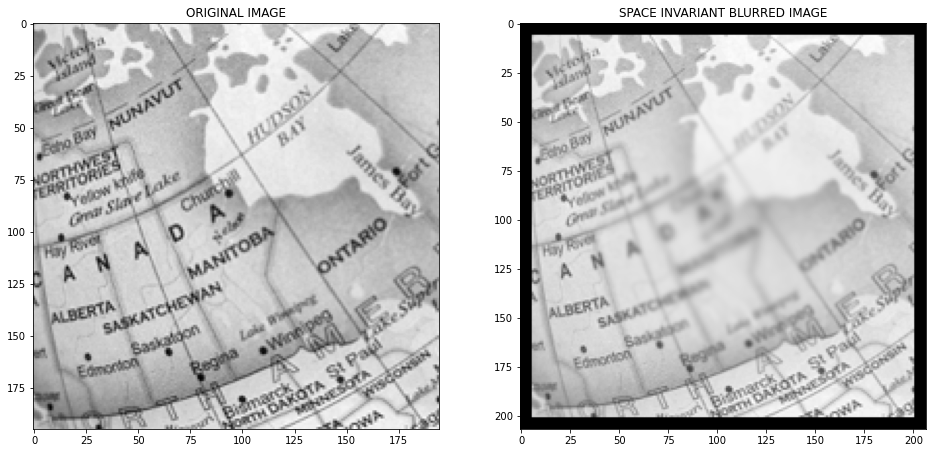

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,16))
ax1.imshow(globe,cmap='gray')
ax1.title.set_text("ORIGINAL IMAGE")
ax2.imshow(blur1,cmap='gray')
ax2.title.set_text("SPACE INVARIANT BLURRED IMAGE")

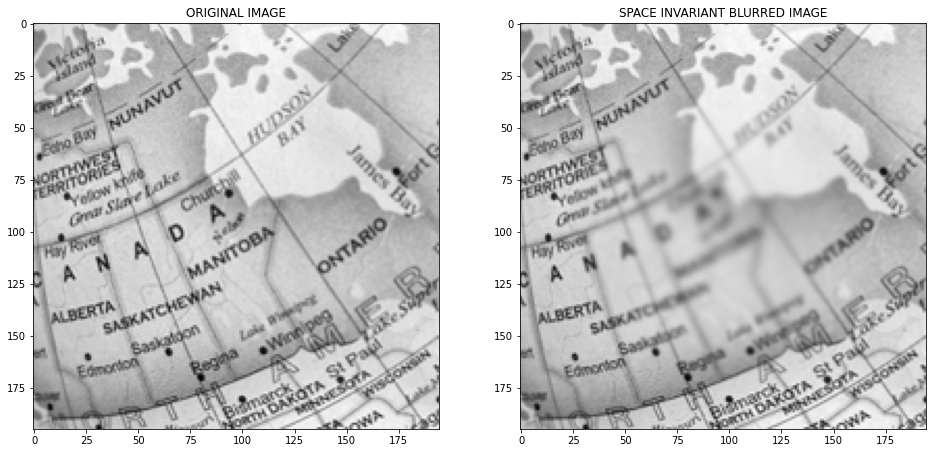

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,16))
ax1.imshow(globe,cmap='gray')
ax1.title.set_text("ORIGINAL IMAGE")
ax2.imshow(blur2,cmap='gray')
ax2.title.set_text("SPACE INVARIANT BLURRED IMAGE")

**CHECKING THE GRAPH OF SIGMA MATRIX TO OBSERVE WHERE IS THE BLURRING EFFECT MAXIMUM**

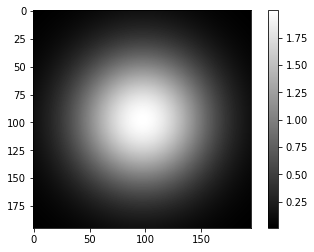

In [26]:
plt.imshow(sigma_matrix,'gray')
plt.colorbar()

# Space Variant Blur vs Space Invariant Blur

**COMPARING SPACE VARIANT AND SPACE INVARIANT BLUR FOR NAUTILUS.PNG IMAGE**


* Space-invariant blur code of part 1 with σ = 1.0, and
* Space-variant blur code of part 2 with σ(m,n) = 1.0 for 0 ≤ m,n ≤ N − 1.

In [27]:
[x,y] = np.shape(nautilus)
sigma = 1.0
blurred1 = convolution_2D(nautilus,sigma)

sigma_matrix = sigma*np.ones((x,y))
blurred2 = space_variant_blur2(nautilus, sigma_matrix)

/var/folders/6g/kp6g8f296vz0ccdjvmzzmxn00000gn/T/ipykernel_53177/3493581476.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return size.astype(np.int)


**SPACE INVARIANT BLUR WITH $\sigma = 1.0$**

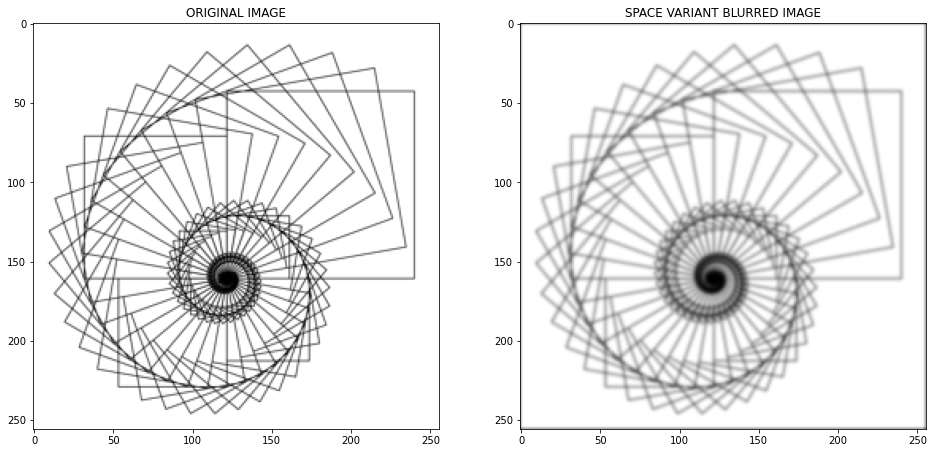

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,16))
ax1.imshow(nautilus,cmap='gray')
ax1.title.set_text("ORIGINAL IMAGE")
ax2.imshow(blurred1,cmap='gray')
ax2.title.set_text("SPACE VARIANT BLURRED IMAGE")

**SPACE VARIANT BLUR WITH σ(m,n) = 1.0 for 0 ≤ m,n ≤ N − 1**

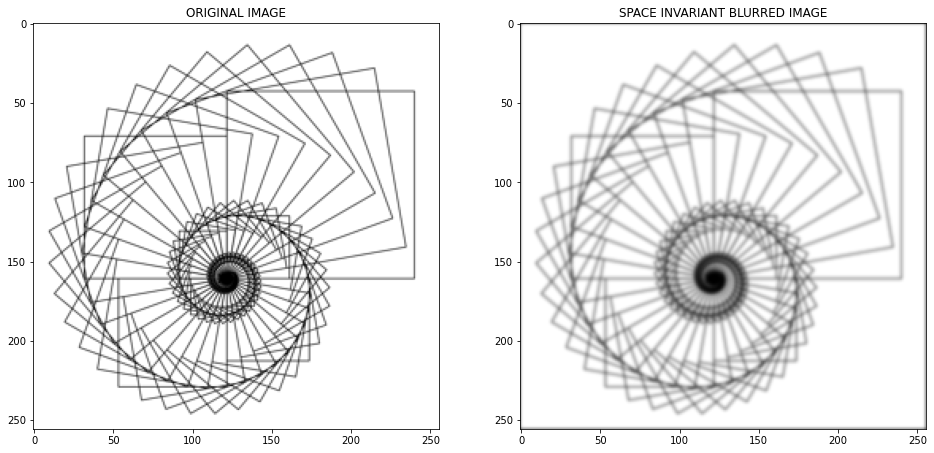

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,16))
ax1.imshow(nautilus,cmap='gray')
ax1.title.set_text("ORIGINAL IMAGE")
ax2.imshow(blurred2,cmap='gray')
ax2.title.set_text("SPACE INVARIANT BLURRED IMAGE")

**COMPARISON OF BOTH**

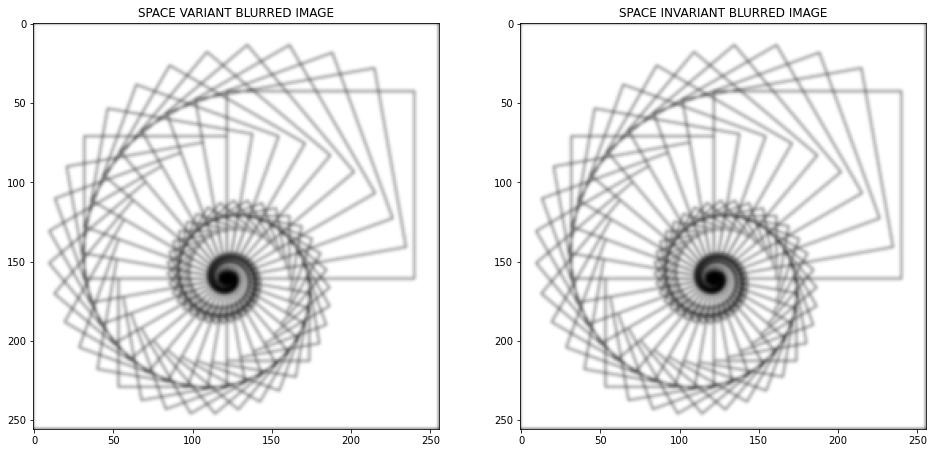

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,16))
ax1.imshow(blurred1,cmap='gray')
ax1.title.set_text("SPACE VARIANT BLURRED IMAGE")
ax2.imshow(blurred2,cmap='gray')
ax2.title.set_text("SPACE INVARIANT BLURRED IMAGE")

**FINDING DIFFERENCE OF BOTH TO OBSERVE THE ERROR**

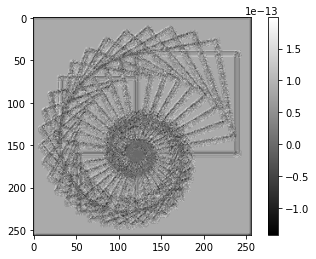

In [31]:
diff = blurred1-blurred2
plt.imshow(diff,cmap='gray')
plt.colorbar()

## OBSERVATIONS:


* In the Globe image we observed that maximum blurring occured at the center of the image and gradullay blurring reduced as we moved to the edges of the image
* We observed that space varying blurring was computationally more intensive that space invarying blurring, since in space variant computation is being done for each pixel i.e. kernel is being multiplied for each intensity pixel and multiple sigma values are being calculated and being used for each pixel making it a computationally intensive task
* We can observe from two different functions **space_variant_blur1** and **space_variant_blur2** that in space_variant_blur1 computational time is being taken more because kernels already computed are being computed again for different sigma values whereas in space_variant_blur2, it is taking less computation time.
* In the image just above, we can observe that difference goes to the value of $e^ {-{13}}$ which can be neglected
* Hence we can say that under certain conditions space variant blur behaves as space invariant blur
* We observed that when blurring matrix is constant then space variant and space invariant blur gives same results.